In [1]:
%load_ext autoreload
%autoreload 2
from APREdatabase import *
from APREmeasures import *
from PacketFeatureTree import *
import pandas as pd

In [2]:
ProtocolsDict = load_protocols(rel_to_root='../../')
p = 'ModBus'
ProtocolsDict[p]

'modbus'

Getting capture csvs for ModBus
../../src/APREdatabase/Protocols/ModBus/ics-github/modbus_ics.csv
../../src/APREdatabase/Protocols/ModBus/netplier/modbus_100.csv


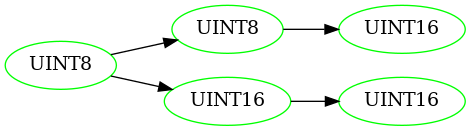

In [3]:
FormatsDF = load_formats(ProtocolsDict, p, rel_to_root='../../')
for capture_df in get_capture_csvs(p, rel_to_root='../../'):
    X, y_lengths, y_syntaxes, y_semantics = parse_df_to_X_y(capture_df, FormatsDF)
    break

TFT = FieldTree(y_syntaxes)
TFT.display()

id


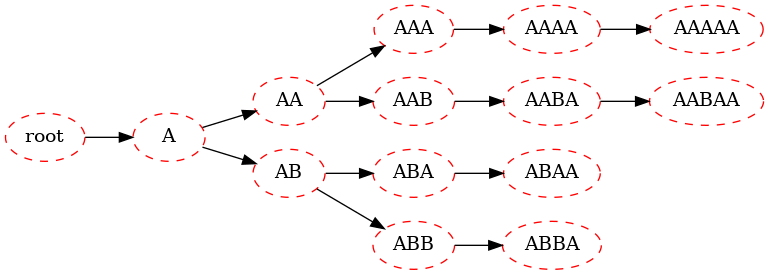

type


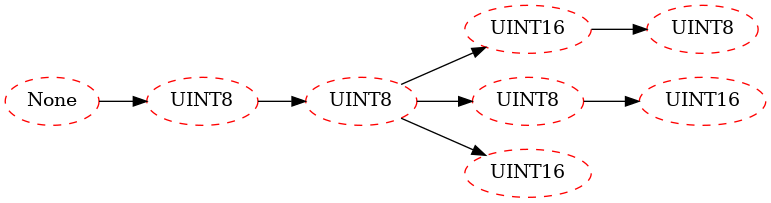

In [4]:
model_file = f'../../src/PacketFeatureTree/ByteLabelModels/clf_{p}.pkl'
pft1 = OneBytePFT(numeric_thresh=3, depth=10000)
pft1.fit(X[:1000])
pft1.show(attr='id')
# load the byte-syntax-probability model
pft2 = LabelledPFT(pft1, model_file)
pft2.fit()
pft2.show()

In [6]:
PN, TN, PND, TNI, score = FieldTreeScore(pft2.tree.children[0], TFT.tree) #dont include the 'root' node
f'Field Tree Score for {p} is {score}: {PN, TN, PND, TNI=}'

dist=2.0


'Field Tree Score for ModBus is 0.86: PN, TN, PND, TNI=(7, 5, 2, 0)'

$$\textbf{Com}(\mathcal{T}, \mathcal{P}) = \frac{|\{ P \in \mathcal{P} : P \sqsubset \mathcal{T}\}|}{|\mathcal{P}|} $$

$$\textbf{Con}(\mathcal{T}, \mathcal{P}) = \frac{|\{ T \in \mathcal{T} : T \sqsubset \mathcal{P}\}|}{|\mathcal{T}|} $$

$$\textbf{Cor}(\mathcal{T}, \mathcal{P}) = \frac{|\{ P\in \mathcal{P} : P \sqsubset \mathcal{T} \} \cup \{P \in \mathcal{P} : \exists T \in \mathcal{T} : T \subseteq P \}|}{|\mathcal{P}|} $$

$$\textbf{Per}(\mathcal{T}, \mathcal{P}) = \frac{|\{ P\in \mathcal{P} : P \in \mathcal{T}\}|}{|\mathcal{P}|} $$


$$\textbf{FMS}(T, P) = \text{ exp} \left( - \left( \frac{|T|-|P|}{|T^b|} \right) ^2 \right) \times \frac{1}{|T^b|}   \displaystyle\sum_{t \in T^b} \text{exp} \left( - \left( \frac{\delta_{tP}}{\gamma } \right) ^2 \right) \\ $$

$\delta_{tP} := \text{ min}_{p \in P^b} \{ |p - t| \}$.

$$\textbf{WAR}(\hat{\mathcal{T}}, \hat{\mathcal{P}}) = \frac{|\{i \in [0,\dots,\mathcal{P}^{(l)}] : t_i=p_i\}|}{|\hat{\mathcal{P}}|} $$


$$\textbf{PS}_n(\hat{T}, \hat{P}) = \frac{\sum_{s \in G_n(\hat{P})} \min (C(s, \hat{P}), C(s, \hat{T}))}{\sum_{s \in G_n(\hat{P})} C(s, \hat{P})} $$


$$ \textbf{BLEU}_k(\hat{T}, \hat{P})=\exp \left[\min \left(0,1-\frac{|\hat{T}|}{|\hat{P}|}\right)\right] \prod_{n=1}^k \textbf{PS}_n(\hat{T}, \hat{P})^{1 / 2^n} $$


$$ \textbf{Lev}(\hat{T}, \hat{P}) = \begin{cases}
    |\hat{T}| & \text{if } |\hat{P}| = 0 \\
    |\hat{P}| & \text{if } |\hat{T}| = 0 \\
    \textbf{Lev}(\{t_2, \dots \}, \{p_2, \dots\}) & \text{if } t_1 = p_1 \\
    1 + \text{min} \begin{cases}
        \textbf{Lev}(\{t_2, \dots \}, \hat{P}) \\
        \textbf{Lev}(\hat{T}, \{p_2, \dots\})\\
        \textbf{Lev}(\{t_2, \dots \}, \{p_2, \dots\})
    \end{cases}
        & \text{otherwise}
\end{cases} $$

$\textbf{LevScore}(\hat{T}, \hat{P}) = 1 - \frac{\textbf{Lev}(\hat{T}, \hat{P})}{max(|\hat{T}|, |\hat{P}|)}$

In [7]:
# Exact single-field match
cases1 = [
    [(0,8),(0,8)],
    [(0,4,8),(0,4,8)],
    [tuple(range(8)), tuple(range(8))]
]

# One true field split in two
cases2 = [
    [(0,8),(0,1,8)],
    [(0,8),(0,2,8)],
    [(0,8),(0,4,8)]
]

# One true field split into many single-length fields
cases3 = [
    [(0,4),(0,1,2,3,4)],
    [(0,8),tuple(range(9))],
    [(0,16),tuple(range(17))]
    ]

# Two true fields covered by a one predicted field
cases4 = [
    [(0,1,8),(0,8)],
    [(0,2,8),(0,8)],
    [(0,4,8),(0,8)]
    ]

# Many single-length true fields covered by one predicted field
cases5 = [
    [(0,1,2,3,4), (0,4)],
    [tuple(range(9)), (0,8)],
    [tuple(range(17)), (0,16)]
    ]

# Staggered fields
cases6 = [
    [(0,2,4,6,8),   (0,1,3,5,7,8)],
    [(0,4,8,12,16), (0,1,5,9,13,16)],
    [(0,8,16,24,32), (0,1,9,17,25,32)]
]

In [8]:
D = {}
D['Case'] = [item for row in [cases1, cases2, cases3, cases4, cases5, cases6] for item in row]
Ts = [F(case[0]) for case in D['Case']]
Ps = [F(case[1]) for case in D['Case']]
global Ts
global Ps

def apply_fn(f):
    return [round(f(T, P), 2) for T, P in zip(Ts, Ps)]

D['Com'] = apply_fn(COM)
D['Con'] = apply_fn(CON)
D['Cor'] = apply_fn(COR)
D['Per'] = apply_fn(PER)
D['FMS'] = apply_fn(FMS)
D['WAR'] = apply_fn(WAR)
D['PS2'] = apply_fn(lambda T, P: PS_n(T, P, n=2))
D['PS4'] = apply_fn(lambda T, P: PS_n(T, P, n=4))
D['PS8'] = apply_fn(lambda T, P: PS_n(T, P, n=8))
D['BLEU'] = apply_fn(bleu)
D['Lev'] = apply_fn(Lev)

df = pd.DataFrame(data=D)
df

,Case,Com,Con,Cor,Per,FMS,WAR,PS2,PS4,PS8,BLEU,Lev
0,"[(0, 8), (0, 8)]",1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00
1,"[(0, 4, 8), (0, 4, 8)]",1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00
2,"[(0, 1, 2, 3, 4, 5, 6, 7), (0, 1, 2, 3, 4, 5, ...",1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00
3,"[(0, 8), (0, 1, 8)]",1.0,0.0,0.0,0.0,0.78,0.89,0.83,0.75,0.00,0.85,0.91
4,"[(0, 8), (0, 2, 8)]",1.0,0.0,0.0,0.0,0.78,0.89,0.67,0.60,0.00,0.75,0.91
5,"[(0, 8), (0, 4, 8)]",1.0,0.0,0.0,0.0,0.78,0.89,0.67,0.33,0.00,0.74,0.91
6,"[(0, 4), (0, 1, 2, 3, 4)]",1.0,0.0,0.0,0.0,0.11,0.40,0.00,0.00,0.00,0.63,0.67
7,"[(0, 8), (0, 1, 2, 3, 4, 5, 6, 7, 8)]",1.0,0.0,0.0,0.0,0.00,0.22,0.00,0.00,0.00,0.47,0.59
8,"[(0, 16), (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1...",1.0,0.0,0.0,0.0,0.00,0.12,0.00,0.00,0.00,0.34,0.55
9,"[(0, 1, 8), (0, 8)]",0.0,1.0,0.0,0.0,0.83,0.89,1.00,1.00,0.00,0.94,0.91
